# Information Retrieval: Programming Assignment \#3

### Sheetal Parikh
EN.605.744.81<br>
October 18, 2021
***
***

In [1]:
#imports for notebook
import sys
import re
import nltk
import os
import string
import struct
import numpy as np
import pandas as pd
import re
import math
import argparse

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem import PorterStemmer
from collections import Counter, namedtuple

# change the current directory 
# to specified directory 
os.chdir(r"C:\Users\Sheetal\Documents\Sheetal\datasets") 

#checking current directory
#print(os.getcwd() + "\n")

#direct path to headlines file
#filepath_docs = '/Users/Sheetal/Documents/Sheetal/datasets/cord19.txt'
#filepath_docs = '/Users/Sheetal/Documents/Sheetal/datasets/animal.txt'
filepath_keyword = '/Users/Sheetal/Documents/Sheetal/datasets/cord19_topics_keyword.txt'
filepath_question = '/Users/Sheetal/Documents/Sheetal/datasets/cord19_topics_question.txt'

### Splitting Dataset to Text Files Containing 42% and 58% of the data

My computer and program wasn't able to process the entire dataset and I had to split the file into textfiles containing 42% and 58% of the data.  For the assignment I used the 42% dataset.  When I tried creating the postings list and dictionary using the entire dataset, I had to stop the program after 4+ hours because it still hadn't processed.

In [2]:
#reading the dataset up until ID 15000
with open('cord19.txt', 'r', encoding = 'utf8') as file:
    text_split = file.read().split('<P ID=80001>')

#splitting and writing 42% of the dataset to a text file
with open('cord19_perc1.txt', 'w', encoding = 'utf8') as file:
    file.write(text_split[0])

#splitting and writing 58% of the dataset to a text file
with open('cord19_perc2.txt', 'w', encoding = 'utf8') as file:
    file.write(text_split[1])

In [3]:
filepath_docs = '/Users/Sheetal/Documents/Sheetal/datasets/cord19_perc1.txt'

### Creating Postings List and Dictionary

The cord19_perc1 text file was preprocessed by having the html tags removed, removing punctuation, applying a stemmmer and removing stop words.  The posting list will be a dictionary that contains the docid and frequency of the word in the document.  The dictionary will be a dictionary that lists the number of documents the term occurs in and the total frequency of the term.  The dictionary and will be created in in the fuction that saves the binary postings list file to disk.  The posting list and dictionary (dictionary objects) will be restructured into the Postings and Words namedtuples to format the data in a more organized way. Similar to the previous assignment, I only used the stemmer as it processed the data faster.  I didn't implement both a lemmatizer and stemmer becauase I thought it would limit the vocabulary.

Even after using a corpus that contained 42% of the data, my program still took about 2 hours to create the index.

In [4]:
import time

#start time for calculating the execution time for creating the index
start = time.time()

#using named tuples to store information in a more organized way
#the Posting tuple will store the docid and the frequency of a word in the specific document
#the Words tuple will store the # of documents that contain the word and the total frequency of the word in the corpus

Postings = namedtuple("Posting", ["doc_id", "word_freq"])
Words = namedtuple("Word", ["total_docs", "offset"])

In [5]:
#importing list of stop words from nltk
stop_words = stopwords.words('english')

#the PortersStemmer from nlkt will be used to stem the words in the corpus
stemmer= PorterStemmer()

In [6]:
#preprocessing the text
def preprocess(text):
    text = re.sub("[{}]".format(string.punctuation), " ", text)
    text = text.split()
    text = [stemmer.stem(i) for i in text]
    text = [i for i in text if not i in stop_words]

    return text

In [7]:
#https://stackoverflow.com/questions/36108621/get-all-html-tags-with-beautiful-soup
#https://stackoverflow.com/questions/8933863/how-to-find-tags-with-only-certain-attributes-beautifulsoup

#function to create postings list

#filepath = direct path to file
def get_postings_list(filepath):
    
    #creating postings list dictionary object
    postings_list = {}
    
    #using BeautifulSoup to parse the headlines txt file
    #content = BeautifulSoup(open(filepath), "html.parser", from_encoding="utf-8")
    with open(filepath, encoding='utf8') as infile:
        content = BeautifulSoup(infile, "html.parser")
    

    #removing html tags, preprocessing text and saving docids and counts of terms
    for i, html_tag in enumerate(content.find_all('p')):
        html_tag.attrs['id']
        
        #preprocessing
        text = preprocess(html_tag.text)
        vocab = Counter(text)

        #adding terms 
        for term, word_freq in vocab.items():
            if not term in postings_list:
                postings_list[term] = []

            postings_list[term].append(Postings(int(html_tag.attrs['id']), word_freq))

    return postings_list

In [8]:
#function to save binary postings list to disk and create dictionary

def postings_to_disk(postings_list, file_output='postings_list_cord.txt'):
    
    #creating corpus dictionary object
    dictionary = {}

    #initial offset
    offset_0 = 0
    
    #writing to file
    with open(file_output, 'wb') as file_toDisk:
        for term in sorted(postings_list):
            
            #offset = total documents containing term * 4 bytes
            total_docs = len(postings_list[term])
            offset = offset_0 * 4

            dictionary[term] = Words(total_docs, offset)
            offset_0 += total_docs
            
            #writing output at binary 4 byte unsigned ; most significant byte stored first
            for posting in sorted(postings_list[term], key=lambda i: i.doc_id):
                file_toDisk.write(posting.doc_id.to_bytes(4, byteorder='big'))
                file_toDisk.write(posting.word_freq.to_bytes(4, byteorder='big'))

    return dictionary

In [9]:
#function to write the dictionary to a file on disk

def dictionary_to_disk(dictionary, file_output="dictionary_cord.txt"):
    with open(file_output, "w", encoding='utf8') as file_toDisk2:
        for term in sorted(dictionary):
            t = dictionary[term]
            file_toDisk2.write("{} {} {}\n".format(term, t.total_docs, t.offset))

In [10]:
#creating postings list
postings_list = get_postings_list(filepath_docs)

In [11]:
#saving binary postings list to disk as well as creating dictionary
dictionary = postings_to_disk(postings_list)

In [12]:
#saving dictionary to a file on disk
dictionary_to_disk(dictionary)

#end time for creating index
end = time.time()

#printing execution time
print(f'The time of execution for creating the index is : {round((end-start)/60,4)} minutes')

The time of execution for creating the index is : 122.0054 minutes


In [13]:
#printing size of dictionary and postings list files in megabytes
file_size_dictionary = os.path.getsize('dictionary_cord.txt')
file_size_postings = os.path.getsize('postings_list_cord.txt')
file_size_original_perc = os.path.getsize('cord19_perc1.txt')
file_size_original = os.path.getsize('cord19.txt')
file_size_difference = file_size_original_perc - (file_size_postings + file_size_dictionary)

print(f'The size of the dictionary file is: {file_size_dictionary/1000000} megabytes')
print(f'The size of the postings list file is: {file_size_postings/1000000} megabytes')
print(f'The size of the original COVID corpus file is: {file_size_original/1000000} megabytes')
print(f'The size of the COVID corpus file used in the assignment is: {file_size_original_perc/1000000} megabytes')
print(f'The size of the entire index is {file_size_difference/1000000} megabytes smaller than the document file used')

The size of the dictionary file is: 4.163236 megabytes
The size of the postings list file is: 86.77004 megabytes
The size of the original COVID corpus file is: 359.302564 megabytes
The size of the COVID corpus file used in the assignment is: 150.802235 megabytes
The size of the entire index is 59.868959 megabytes smaller than the document file used


### Summarizing Stats about the Dataset

As can be seen above, the dictionary and postings list files combined are smaller than the original COVID corpus text.  The postings list file takes up more space than the dictionary file.  As seen below, there are 79,958 documents.  Since I included all the documents with ID's less than 80,001, I was expecting there to be 80,000 documents.  It's possible that two documents may have not included any of the words included in the vocabulary.

<br>
I took a screenshot of the printed posting list and dictionary and added it at the end of the notebook.  Keeping the posting list and dictionary displayed in the jupyter notebook was causing print to pdf to crash.

In [ ]:
#viewing posting_list - please see screenshot at end of document
#postings_list

In [ ]:
#viewing dictionary - please see screenshot at end of document
#dictionary

In [14]:
#General cord19_perc1.txt file stats
unique_words = len(postings_list.keys())
total_words = sum([Word.word_freq for posting in postings_list.values() for Word in posting])
total_documents = len(set([Word.doc_id for posting in postings_list.values() for Word in posting]))

print(f'Total Words: {total_words}')
print(f'Total Unique Words: {unique_words}')
print(f'Total Documents/Paragraphs: {total_documents}')

Total Words: 196764687
Total Unique Words: 197478
Total Documents/Paragraphs: 79958


### Creating Search Engine

The function below takes the query and postings list and returns the document id and similarity score for the top 100 documents using the dot product method due to time constraints.

In [15]:
#function to compute similarity score of document and query using the dot product method
#limit to top 100 documents per query
#input the query and postings list
def dot_product_rank(query, posting_list, limit=100): 
    #creating bag of words
    bagOfWords_query = Counter(query)
    queryVector = [bagOfWords_query[item] for item in sorted(bagOfWords_query.keys())]

    doc_freq = []
    for key in sorted(bagOfWords_query.keys()):
        doc_freq.append(len(posting_list[key]))

    scores = dict()
    for i, term in enumerate(sorted(bagOfWords_query.keys())):
        for posting in posting_list[term]:
            #give a score of 0 if can't find 
            if not posting.doc_id in scores:
                scores[posting.doc_id] = 0
            else: 
                #compute dot product
                scores[posting.doc_id] += np.dot(queryVector[i],posting.word_freq)
                
    #sorting the top documents that have a score
    ranked_docs = sorted(scores, key=lambda item: scores[item])[::-1]
    
    #returns the document ind the similarity score for the top 100 documents
    return [(doc_id, scores[doc_id]) for doc_id in ranked_docs[:limit]]

### Processing Query Keyword Text File

As can be seen below, the first query from the keyword text file, includes the words coronovaviru and origin, each of which have a frequency of 1.  The ranking file processed in less than a minute.

In [16]:
#starting time of processing the keyword queries
start2 = time.time()

#dictionary of the words in the keyword text file
queries_keyword = {}

#opening and preprocessing query text file
with open("cord19_topics_keyword.txt", encoding='utf8') as infile2:
    query_content = BeautifulSoup(infile2, "html.parser")
    #removing html tags
    for i, html_tag in enumerate(query_content.find_all('q')):
        html_tag.attrs['id']
        queries_keyword[int(html_tag.attrs['id'])] = preprocess(html_tag.text)

#the first query: the word and frequency of the word in the document
first_query_keyword = Counter(queries_keyword[sorted(queries_keyword)[0]])

print(first_query_keyword)

Counter({'coronaviru': 1, 'origin': 1})


In [17]:
#opening text file for writing
with open("sparikh6-a.txt", 'w') as outfile:
    for query_id in sorted(queries_keyword):
        queries = queries_keyword[query_id]
        #computing similarity score
        sim_scores = dot_product_rank(queries, postings_list)

        #writing to the file in the format: queryID Q0 doc_id ("1 Q0 doc_id rank score jhedID")
        for i, (doc_id, score) in enumerate(sim_scores):
            outfile.write("{} Q0 {} {} {} sparikh6\n".format(query_id, doc_id, i+1, score))
            
#end time of processing the keyword queries
end2 = time.time()

print(f'The time of execution for processory the query key word file is: {round((end2-start2)/60,4)} minutes')

The time of execution for processory the query key word file is: 0.0355 minutes


In [18]:
#printing size of the rankings file
file_size_rankings = os.path.getsize('sparikh6-a.txt')
print(f'The size of the rankings file is: {file_size_rankings/1000000} megabytes')

The size of the rankings file is: 0.140187 megabytes


### Length Experiment: Processing Query Questions Text File

As can be seen below, the first query from the keyword text file, includes the words origin, covid, and 19, each of which have a frequency of 1.  Since the corpus includes covid related documents, it may have been beneficial to convert the numbers to words to have a better vocabulary set. The ranking file processed in less than a minute as well.  The file size of the ranking file using the questions text file is a little larger than the query keyword ranking file.

In [19]:
#starting time of processing the question queries
start3 = time.time()

#dictionary of the words in the question text file
queries_questions = {}

#opening and preprocessing query text file
with open("cord19_topics_question.txt", encoding='utf8') as infile3:
    query_content2 = BeautifulSoup(infile3, "html.parser")
    #removing html tags
    for i, html_tag in enumerate(query_content2.find_all('q')):
        html_tag.attrs['id']
        queries_questions[int(html_tag.attrs['id'])] = preprocess(html_tag.text)
        
#the first query: the word and frequency of the word in the document
first_query_question = Counter(queries_questions[sorted(queries_questions)[0]])

print(first_query_question)

Counter({'origin': 1, 'covid': 1, '19': 1})


In [20]:
#opening text file for writing
with open("sparikh6-b.txt", 'w') as outfile:
    for query_id in sorted(queries_questions):
        queries2 = queries_questions[query_id]
        #computing similarity score
        sim_scores2 = dot_product_rank(queries2, postings_list)

        #writing to the file in the format: queryID Q0 doc_id ("1 Q0 doc_id rank score jhedID")
        for i, (doc_id, score) in enumerate(sim_scores2):
            outfile.write("{} Q0 {} {} {} sparikh6\n".format(query_id, doc_id, i+1, score))
            
#end time of processing the keyword queries
end3 = time.time()

print(f'The time of execution for processory the query key word file is: {round((end2-start2)/60,4)} minutes')

The time of execution for processory the query key word file is: 0.0355 minutes


In [25]:
#printing size of the rankings file
file_size_rankings = os.path.getsize('sparikh6-b.txt')
print(f'The size of the rankings file is: {file_size_rankings/1000000} megabytes')

The size of the rankings file is: 0.142862 megabytes


#### Comparing the Ranking Files

I printed the first 15 rankings from both the ranking file including the keywords and questions.

In [23]:
#function for reading n lines from the text file
def read_n_lines(filename,n,mode='r+'):
    with open(filename) as f:
        for i in range(n):
            print(f.readline())

#read the first 15 rankings of the keyword ranking file
read_n_lines('sparikh6-a.txt',15)            

1 Q0 5330 1 4664 sparikh6

1 Q0 12367 2 4000 sparikh6

1 Q0 12910 3 3943 sparikh6

1 Q0 13000 4 3925 sparikh6

1 Q0 13225 5 3916 sparikh6

1 Q0 21730 6 3253 sparikh6

1 Q0 24056 7 3000 sparikh6

1 Q0 29998 8 2522 sparikh6

1 Q0 34982 9 2346 sparikh6

1 Q0 37364 10 2278 sparikh6

1 Q0 37379 11 2277 sparikh6

1 Q0 39857 12 2187 sparikh6

1 Q0 40567 13 2157 sparikh6

1 Q0 42013 14 2117 sparikh6

1 Q0 49963 15 1890 sparikh6



In [24]:
#read the first 15 rankings of the question ranking file
read_n_lines('sparikh6-b.txt',15)  

1 Q0 5330 1 67989 sparikh6

1 Q0 12367 2 67156 sparikh6

1 Q0 12910 3 67099 sparikh6

1 Q0 13000 4 67081 sparikh6

1 Q0 13225 5 67072 sparikh6

1 Q0 21730 6 66335 sparikh6

1 Q0 24056 7 65409 sparikh6

1 Q0 29998 8 61852 sparikh6

1 Q0 34982 9 59173 sparikh6

1 Q0 37364 10 58059 sparikh6

1 Q0 37379 11 58047 sparikh6

1 Q0 39857 12 56811 sparikh6

1 Q0 40567 13 56421 sparikh6

1 Q0 42013 14 55580 sparikh6

1 Q0 49963 15 51347 sparikh6



##### Screenshot of Postings List and Dictionary
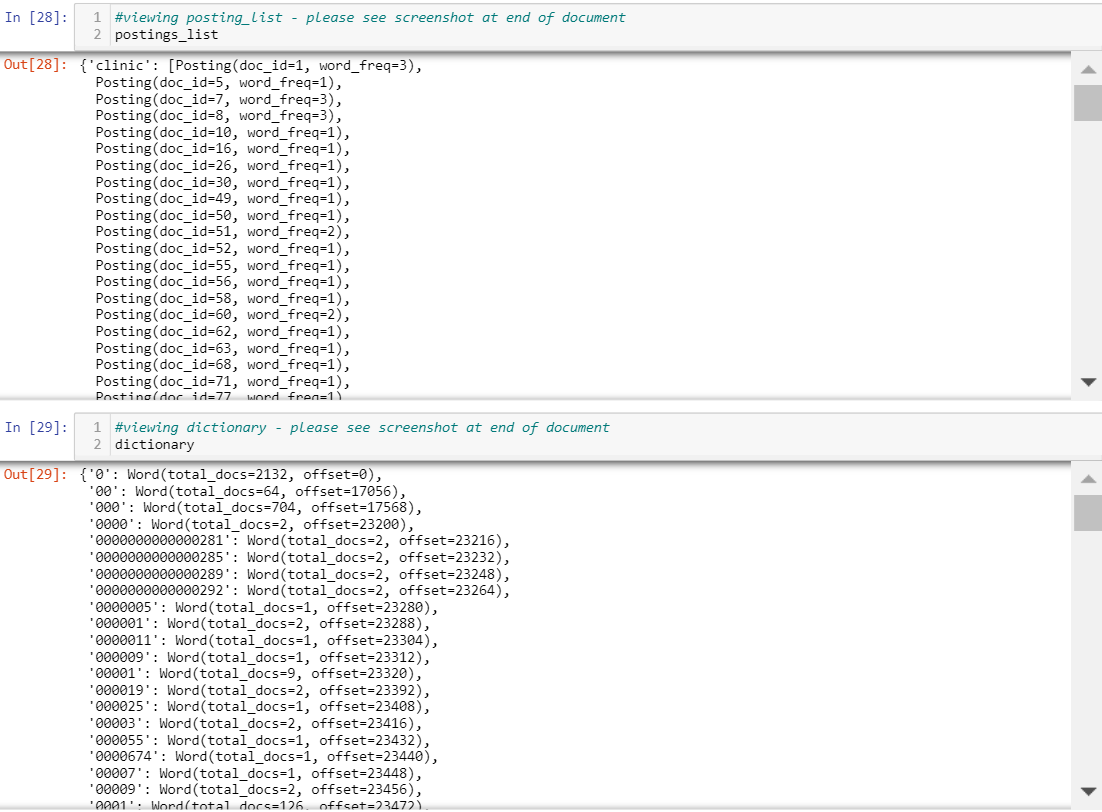

### References
https://stackoverflow.com/questions/36108621/get-all-html-tags-with-beautiful-soup

https://stackoverflow.com/questions/8933863/how-to-find-tags-with-only-certain-attributes-beautifulsoup

https://docs.python.org/3/library/collections.html

https://docs.python.org/3/library/string.html

https://www.geeksforgeeks.org/how-to-convert-int-to-bytes-in-python/

https://towardsdatascience.com/python-pro-tip-start-using-python-defaultdict-and-counter-in-place-of-dictionary-d1922513f747

https://realpython.com/python-namedtuple/

https://medium.com/analytics-vidhya/python-list-vs-tuple-vs-dictionary-4a48655c7934

https://stackoverflow.com/questions/8710456/reading-a-binary-file-with-python

https://www.geeksforgeeks.org/how-to-get-file-size-in-python/

https://stackoverflow.com/questions/30750843/python-3-unicodedecodeerror-charmap-codec-cant-decode-byte-0x9d

https://stackoverflow.com/questions/52545749/splitting-a-file-into-multiple-files-with-a-key-word-using-python